In [1]:
import duckdb

con = duckdb.connect("gdelt.duckdb")

In [27]:
con.execute("DROP TABLE IF EXISTS gdelt_raw;")
con.execute("DROP TABLE IF EXISTS gdelt_protests;")


In [37]:
import zipfile
from pathlib import Path

input_dir = Path(r"C:\Users\matia\Desktop\Statistik 2\Rohdaten_ZIP")
output_dir = Path(r"C:\Users\matia\Desktop\Statistik 2\Rohdaten_extrahiert")

output_dir.mkdir(parents=True, exist_ok=True)

zip_files = sorted(input_dir.glob("*.zip"))

print(f"{len(zip_files)} ZIP-Dateien gefunden")

for zip_path in zip_files:
    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(output_dir)
        print(f"✔ extrahiert: {zip_path.name}")
    except Exception as e:
        print(f"✖ Fehler bei {zip_path.name}: {e}")


1824 ZIP-Dateien gefunden
✔ extrahiert: 20190101.export.CSV.zip
✔ extrahiert: 20190102.export.CSV.zip
✔ extrahiert: 20190103.export.CSV.zip
✔ extrahiert: 20190104.export.CSV.zip
✔ extrahiert: 20190105.export.CSV.zip
✔ extrahiert: 20190106.export.CSV.zip
✔ extrahiert: 20190107.export.CSV.zip
✔ extrahiert: 20190108.export.CSV.zip
✔ extrahiert: 20190109.export.CSV.zip
✔ extrahiert: 20190110.export.CSV.zip
✔ extrahiert: 20190111.export.CSV.zip
✔ extrahiert: 20190112.export.CSV.zip
✔ extrahiert: 20190113.export.CSV.zip
✔ extrahiert: 20190114.export.CSV.zip
✔ extrahiert: 20190115.export.CSV.zip
✔ extrahiert: 20190116.export.CSV.zip
✔ extrahiert: 20190117.export.CSV.zip
✔ extrahiert: 20190118.export.CSV.zip
✔ extrahiert: 20190119.export.CSV.zip
✔ extrahiert: 20190120.export.CSV.zip
✔ extrahiert: 20190121.export.CSV.zip
✔ extrahiert: 20190122.export.CSV.zip
✔ extrahiert: 20190123.export.CSV.zip
✔ extrahiert: 20190124.export.CSV.zip
✔ extrahiert: 20190125.export.CSV.zip
✔ extrahiert: 20190126.e

Proteste (EventRootCode = 14) direkt beim Einlesen filtern

In [46]:
con.execute("""
PRAGMA table_info('gdelt_raw');
""").fetchall()


CatalogException: Catalog Error: Table with name gdelt_raw does not exist!
Did you mean "pg_tables"?

In [2]:
import duckdb

con = duckdb.connect("gdelt.duckdb")

con.execute("""
DROP TABLE IF EXISTS gdelt_events_filtered;

CREATE TABLE gdelt_events_filtered AS
SELECT
    column00 AS global_event_id,
    TRY_CAST(column01 AS INTEGER) AS sql_date,
    TRY_CAST(column03 AS INTEGER) AS year,

    TRY_CAST(column26 AS INTEGER) AS event_root_code,
    column27 AS event_base_code,
    TRY_CAST(column30 AS DOUBLE) AS goldstein_scale,

    column06 AS actor1_code,
    column16 AS actor2_code,

    column52 AS action_country
FROM read_csv(
    [
      'C:/Users/matia/Desktop/Statistik 2/Rohdaten_extrahiert/201901*.export.CSV',
      'C:/Users/matia/Desktop/Statistik 2/Rohdaten_extrahiert/201902*.export.CSV',
      'C:/Users/matia/Desktop/Statistik 2/Rohdaten_extrahiert/201903*.export.CSV',
      'C:/Users/matia/Desktop/Statistik 2/Rohdaten_extrahiert/201904*.export.CSV',
      'C:/Users/matia/Desktop/Statistik 2/Rohdaten_extrahiert/201905*.export.CSV',
      'C:/Users/matia/Desktop/Statistik 2/Rohdaten_extrahiert/201906*.export.CSV'
    ],
    delim = '\t',
    header = false,
    all_varchar = true,
    ignore_errors = true,
    null_padding = true,
    max_line_size = 10000000
)
WHERE TRY_CAST(column26 AS INTEGER) IN (14, 18);
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Polizei dummy

In [54]:
con.execute("""
DROP TABLE IF EXISTS gdelt_events_with_police;

CREATE TABLE gdelt_events_with_police AS
SELECT
    *,
    CASE
        WHEN
            actor1_code LIKE 'POL%' OR
            actor2_code LIKE 'POL%'
        THEN 1
        ELSE 0
    END AS police_involved
FROM gdelt_events_filtered;
""")


In [55]:
con.execute("""
DROP TABLE IF EXISTS gdelt_events_with_police;

CREATE TABLE gdelt_events_with_police AS
SELECT
    *,
    CASE
        WHEN
            actor1_code LIKE 'POL%' OR
            actor2_code LIKE 'POL%'
        THEN 1
        ELSE 0
    END AS police_involved
FROM gdelt_events_filtered;
""")


In [56]:
con.execute("""
SELECT
    police_involved,
    COUNT(*) AS anzahl
FROM gdelt_events_with_police
GROUP BY police_involved
ORDER BY police_involved;
""").fetchall()


[(0, 302894), (1, 8103)]

Gewalt dummy

In [57]:
con.execute("""
DROP TABLE IF EXISTS gdelt_events_with_police_violence;

CREATE TABLE gdelt_events_with_police_violence AS
SELECT
    *,
    CASE
        WHEN event_root_code = 18 THEN 1
        ELSE 0
    END AS violence
FROM gdelt_events_with_police;
""")


In [58]:
con.execute("""
SELECT
    violence,
    COUNT(*) AS anzahl
FROM gdelt_events_with_police_violence
GROUP BY violence
ORDER BY violence;
""").fetchall()


[(0, 256987), (1, 54010)]

In [59]:
con.execute("""
SELECT
    police_involved,
    violence,
    COUNT(*) AS anzahl
FROM gdelt_events_with_police_violence
GROUP BY police_involved, violence
ORDER BY police_involved, violence;
""").fetchall()


[(0, 0, 250735), (0, 1, 52159), (1, 0, 6252), (1, 1, 1851)]

Gewanltanteile berechnen

In [60]:
import pandas as pd

# Gewaltanteil nach Polizeinennung berechnen
query = """
SELECT
    police_involved,
    SUM(violence) * 1.0 / COUNT(*) AS violence_share
FROM gdelt_events_with_police_violence
GROUP BY police_involved
ORDER BY police_involved;
"""

data = con.execute(query).fetchall()

df_plot = pd.DataFrame(
    data,
    columns=["police_involved", "violence_share"]
)

df_plot["police_involved"] = df_plot["police_involved"].map({
    0: "Ohne Polizeinennung",
    1: "Mit Polizeinennung"
})


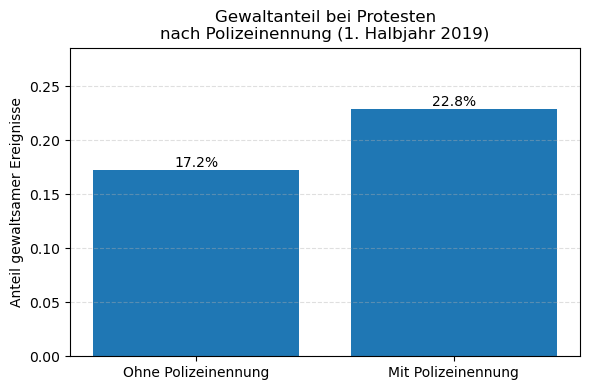

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(df_plot["police_involved"], df_plot["violence_share"])

plt.ylabel("Anteil gewaltsamer Ereignisse")
plt.title("Gewaltanteil bei Protesten\nnach Polizeinennung (1. Halbjahr 2019)")

plt.ylim(0, df_plot["violence_share"].max() * 1.25)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Werte über Balken schreiben
for i, v in enumerate(df_plot["violence_share"]):
    plt.text(i, v, f"{v:.1%}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [62]:
import pandas as pd

query = """
SELECT
    police_involved,
    goldstein_scale
FROM gdelt_events_with_police_violence
WHERE goldstein_scale IS NOT NULL;
"""

data = con.execute(query).fetchall()

df_box = pd.DataFrame(
    data,
    columns=["police_involved", "goldstein_scale"]
)

df_box["police_involved"] = df_box["police_involved"].map({
    0: "Ohne Polizeinennung",
    1: "Mit Polizeinennung"
})


<Figure size 600x400 with 0 Axes>

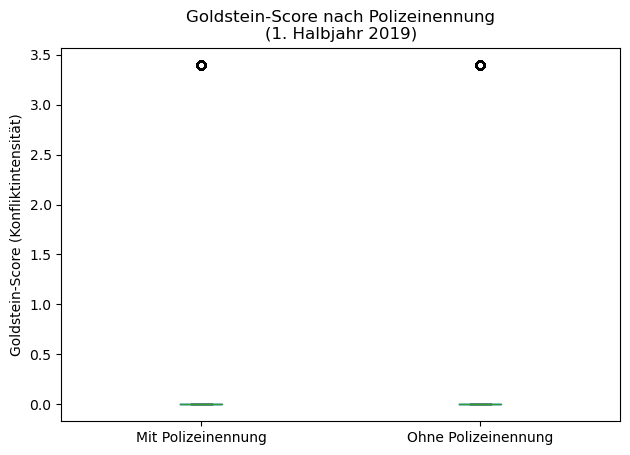

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

df_box.boxplot(
    column="goldstein_scale",
    by="police_involved",
    grid=False
)

plt.title("Goldstein-Score nach Polizeinennung\n(1. Halbjahr 2019)")
plt.suptitle("")  # entfernt automatischen Pandas-Titel
plt.ylabel("Goldstein-Score (Konfliktintensität)")
plt.xlabel("")

plt.tight_layout()
plt.show()


In [65]:
con.execute("""
CREATE OR REPLACE VIEW violence_summary AS
SELECT
    police_involved,
    violence,
    COUNT(*) AS n_events
FROM gdelt_events_with_police_violence
GROUP BY police_involved, violence
ORDER BY police_involved, violence
""")

In [67]:
import duckdb

con = duckdb.connect("gdelt.duckdb")

con.execute("""
CREATE OR REPLACE VIEW violence_share AS
SELECT
    police_involved,
    SUM(CASE WHEN violence = 1 THEN n_events ELSE 0 END) * 1.0
    / SUM(n_events) AS share_violent
FROM violence_summary
GROUP BY police_involved
""")


In [68]:
df_plot = con.execute("""
SELECT
    CASE
        WHEN police_involved = 1 THEN 'Mit Polizeinennung'
        ELSE 'Ohne Polizeinennung'
    END AS category,
    share_violent
FROM violence_share
""").df()


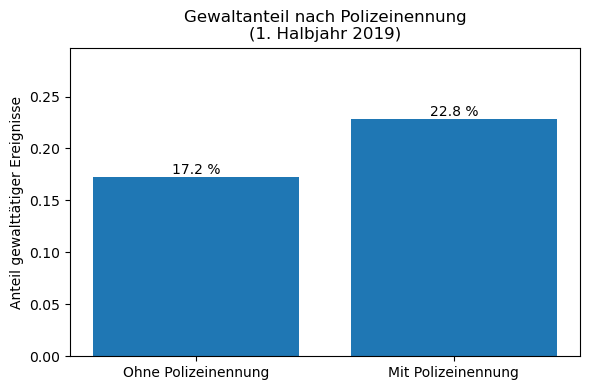

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
bars = plt.bar(
    df_plot["category"],
    df_plot["share_violent"]
)

plt.ylabel("Anteil gewalttätiger Ereignisse")
plt.title("Gewaltanteil nach Polizeinennung\n(1. Halbjahr 2019)")
plt.ylim(0, df_plot["share_violent"].max() * 1.3)

# Prozentwerte über die Balken schreiben
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height * 100:.1f} %",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()
